<a href="https://colab.research.google.com/github/100jy/voice_competition/blob/master/%EB%8D%B0%EC%9D%B4%ED%84%B0_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA 및 방향 잡기


## MFCC를 통한 확인


In [1]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
# 모듈 임포트
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
import librosa
import librosa.display

In [ ]:
data = pd.read_pickle('drive/My Drive/data/x_trian_MFCC.pickle')
data = data.values

In [98]:
label =pd.read_csv('drive/My Drive/data/train_answer.csv',index_col=0)

In [ ]:
idx = [0,2000,4000,8000,10000]
labels = []
for i in idx:
  tmp = list(label.columns[label.iloc[i,:] != 0])
  string = ''
  for j in tmp: 
    string += '_'+j
  labels.append(string)

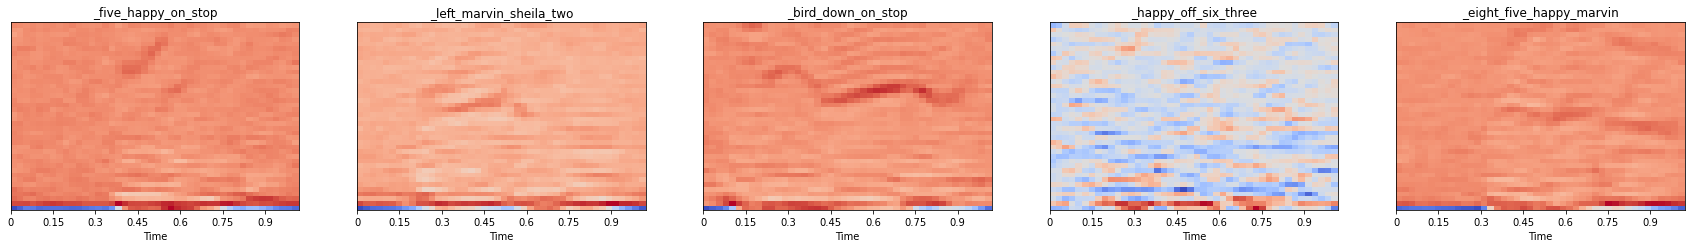

In [ ]:
plt.figure(figsize=(30,20))
for i,j in enumerate(idx):
  s = '55'+str(i+1)
  plt.subplot(int(s))
  mfcc = data[j].reshape(40,-1)
  librosa.display.specshow(mfcc, x_axis='time')
  plt.title(labels[i])

발화하는 단어에 따라 MFCC가 확실히 구분이 간다...

## scale 이후 변화 확인


In [3]:
data = pd.read_pickle('drive/My Drive/data/x_trian_MFCC.pickle')
data = data.values

In [ ]:
x_scale = list((map(lambda x : x / max(abs(x)),data)))

In [ ]:
idx = [0,2000,4000,8000,10000]
labels = []
for i in idx:
  tmp = list(label.columns[label.iloc[i,:] != 0])
  string = ''
  for j in tmp: 
    string += '_'+j
  labels.append(string)

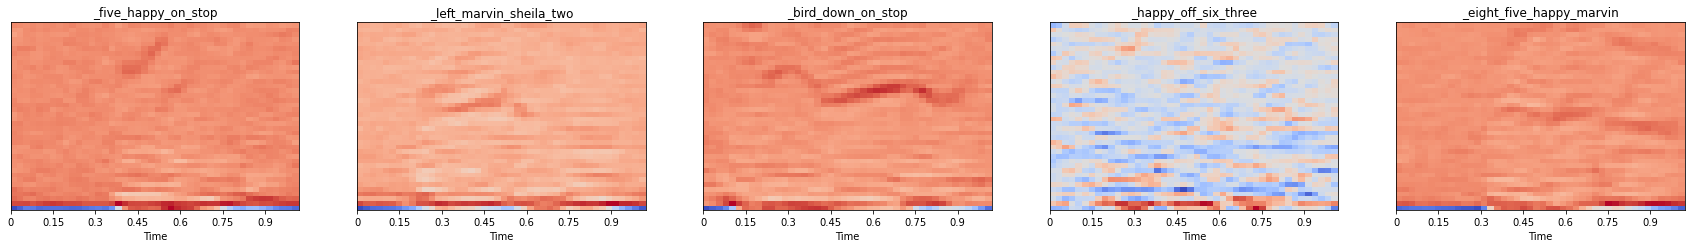

In [ ]:
plt.figure(figsize=(30,20))
for i,j in enumerate(idx):
  s = '55'+str(i+1)
  plt.subplot(int(s))
  mfcc = x_scale[j].reshape(40,-1)
  librosa.display.specshow(mfcc, x_axis='time')
  plt.title(labels[i])

scale후에도 정보의 손실 거의 없다...


# augmentation을 통한 성능향상

In [4]:
#noising
def noising(data,noise_factor):
  noise = np.random.rand(len(data)) * noise_factor 
  augmented = data + noise
  return augmented

# shifting
def shifting(data,direc):
  result  = np.zeros_like(data)
  k = int(np.random.randint(1,3) * (len(data)/15))
  #right
  if direc == '0':
    result[k:] = data[:len(data)-k]
  else:
    result[:len(data)-k] = data[k:]
  return result

#pith를 조절
def change_pitch(data,sr,k):
  return librosa.effects.pitch_shift(data,sr, k)

In [3]:
data_11kH = pd.read_pickle('drive/My Drive/data/x_trian_sr_11025.pickle')
data_11kH = data_11kH.values

In [6]:
data_MFCC = pd.read_pickle('drive/My Drive/data/x_trian_MFCC.pickle')
data_MFCC = data_MFCC.values

In [120]:
noise_fac = 0.05
data_noise = noising(data_11kH[0],noise_fac)
data_shifted = shifting(data_11kH[0],0)
pitch_factor = np.random.rand(1)
data_pitch = change_pitch(data_11kH[0],11025, pitch_factor)

In [121]:
aug_data = [data_MFCC[0],data_11kH[0],data_noise,data_shifted,data_pitch]
labels = ['original_22kh','original_11kh','+noise','shifted','changed_pitch']

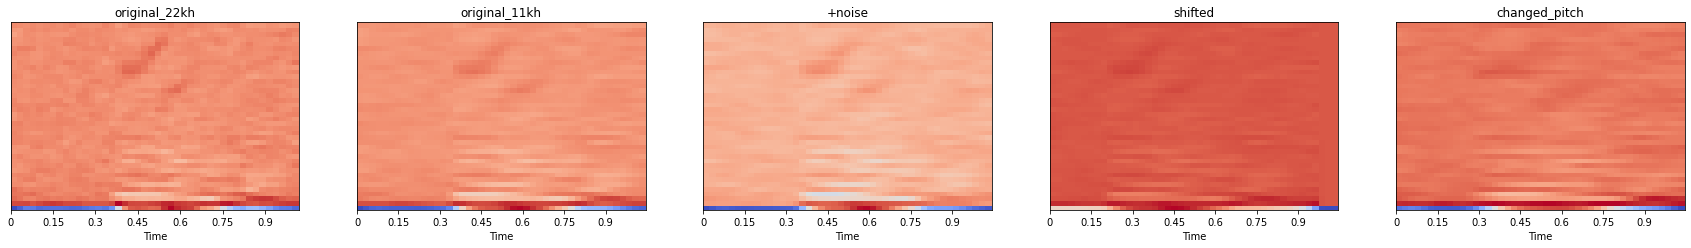

In [122]:
plt.figure(figsize=(30,20))
for i,data in enumerate(aug_data):
  s = '55'+str(i+1)
  plt.subplot(int(s))
  if i == 0:
    mfcc = data.reshape(40,-1)
    librosa.display.specshow(mfcc, x_axis='time')
  else:
    mfcc = librosa.feature.mfcc(data,sr = 11025, n_mfcc=40, fmax=3000, hop_length = int(11025/44))
    librosa.display.specshow(mfcc, x_axis='time')
  plt.title(labels[i])

In [130]:
idx = [0,10,100,1000,5000]
true= []
for i in idx:
  tmp = list(label.columns[label.iloc[i,:] != 0])
  string = ''
  for j in tmp: 
    string += '_'+j
  true.append(string)

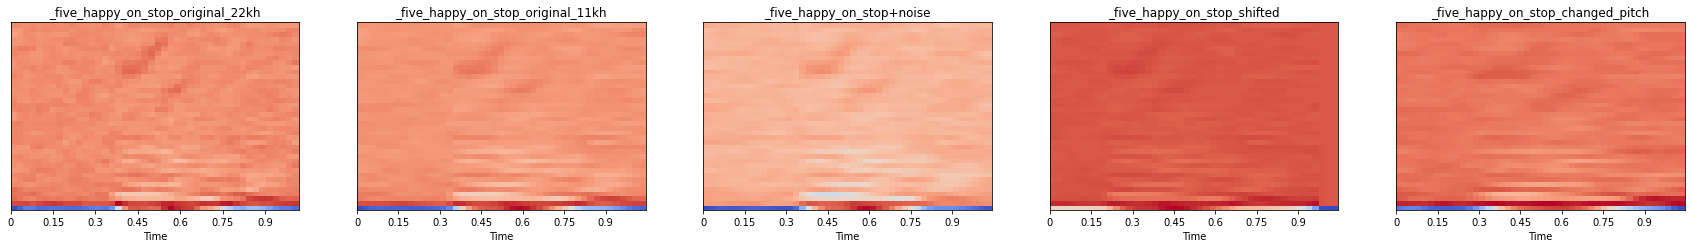

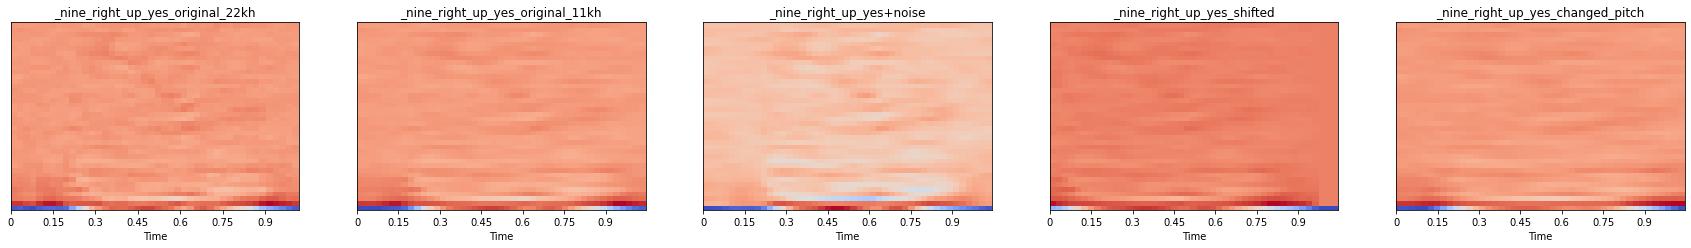

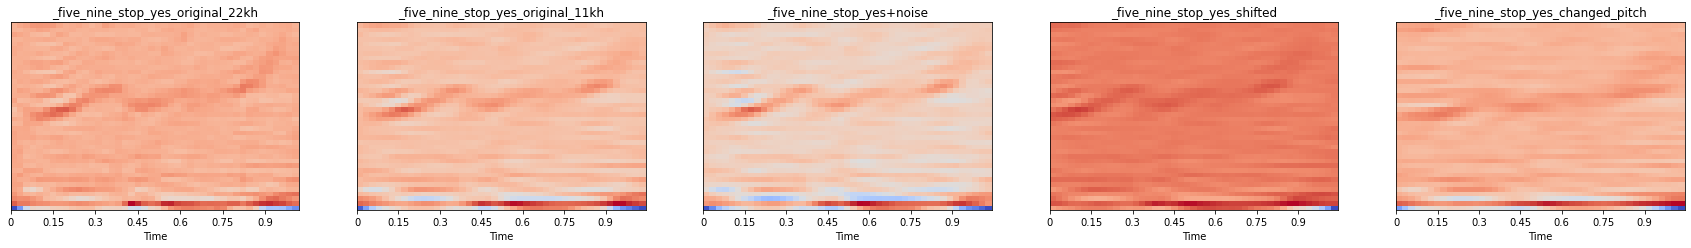

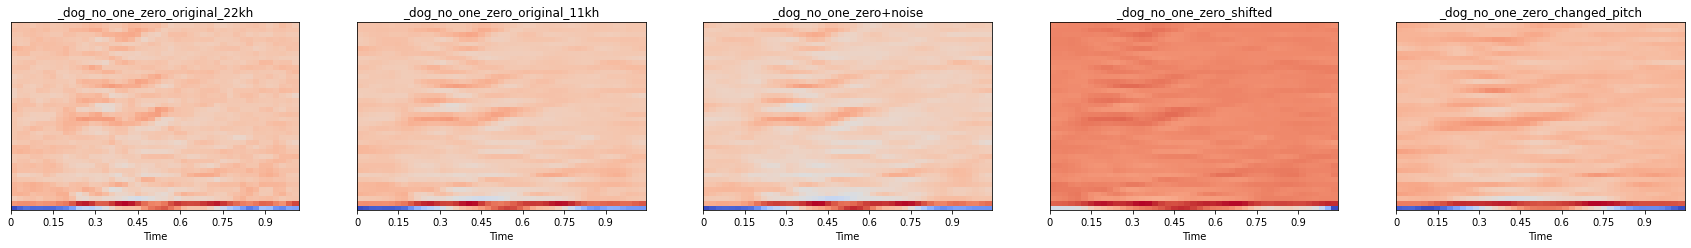

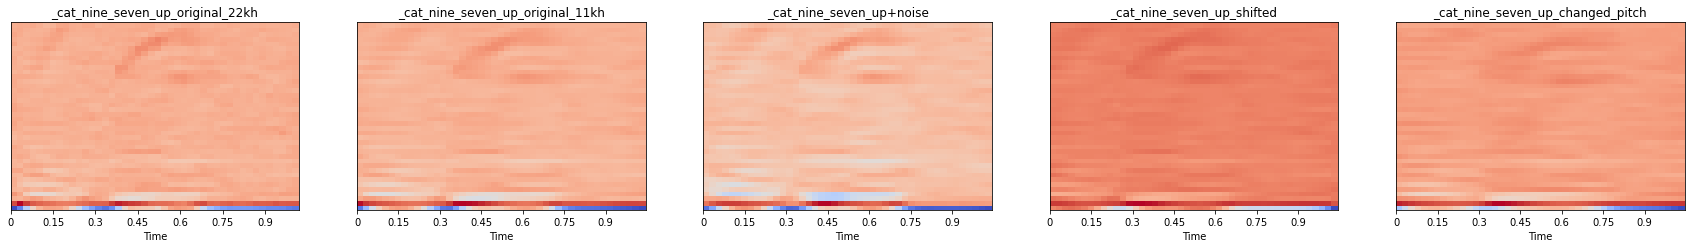

In [131]:
for k in range(5):

  noise_fac = 0.05
  data_noise = noising(data_11kH[k],noise_fac)
  data_shifted = shifting(data_11kH[k],0)
  pitch_factor = np.random.rand(1)
  data_pitch = change_pitch(data_11kH[k],11025, pitch_factor)

  aug_data = [data_MFCC[k],data_11kH[k],data_noise,data_shifted,data_pitch]
  labels = [true[k]+'_original_22kh',true[k]+'_original_11kh',true[k]+'+noise',true[k]+'_shifted',true[k]+'_changed_pitch']
  plt.figure(figsize=(30,20))

  for i,data in enumerate(aug_data):
    s = '55'+str(i+1)
    plt.subplot(int(s))
    if i == 0:
      mfcc = data.reshape(40,-1)
      librosa.display.specshow(mfcc, x_axis='time',sr = 22050)
    else:
      #output length = (seconds) * (sample rate) / (hop_length)
      mfcc = librosa.feature.mfcc(data,sr = 11025, n_mfcc=40, fmax=3000, hop_length = int(11025/44))
      librosa.display.specshow(mfcc, x_axis='time',sr = 22050)
    plt.title(labels[i])

22khz 샘플링 보다 11kh 샘플링이 더 선명하지 못하지만 두개가 같다고 인식할 정도는 된다. 마찬가지로 피치조절과 노이즈 추가 좌우 이동의 경우도 같은 형태를 가지고 있다.


# 데이터 보충

In [11]:
def augmentation(data):
  new_data = []
  from tqdm.notebook import tqdm
  for cont in tqdm(data):
    #noise
    noise_fac = 0.05
    noise = librosa.feature.mfcc(noising(cont,noise_fac),sr = 11025, n_mfcc=40, fmax=3000, hop_length = int(11025/44))
    new_data.append(noise)
    #shifting
    direc = np.random.randint(0,1)
    shifted = librosa.feature.mfcc(shifting(cont,direc),sr = 11025, n_mfcc=40, fmax=3000, hop_length = int(11025/44))
    new_data.append(shifted)
    #pitch_change
    pitch_factor = np.random.rand(1)
    pitch = librosa.feature.mfcc(change_pitch(cont,11025,pitch_factor),sr = 11025, n_mfcc=40, fmax=3000, hop_length = int(11025/44))
    new_data.append(pitch)

  return pd.DataFrame(new_data)

In [12]:
new_data  = augmentation(data_11kH)
new_data.to_pickle('drive/My Drive/data/x_trian_augmented_mfcc.pickle')

KeyboardInterrupt: ignored